# Event Study

_All strange and terrible events are welcome, but comforts we despise_ - Cleopatra

Event studies are a fundamental tool in financial research used to assess how specific events impact stock returns, see Mackinlay (1997). These events, such as mergers, earnings announcements, or regulatory changes, can cause deviations in stock prices known as abnormal returns. By comparing stock returns to a market benchmark, event studies help analysts determine whether an event had a statistically significant impact on a company’s stock price.

This notebook explores key methodologies used in event studies, including the computation of abnormal returns, cumulative abnormal returns, and buy-and-hold abnormal returns. Additionally, it delves into the announcement effect, which examines how stock prices react immediately around an event, and investigates potential pre- and post-announcement drifts. To account for overlapping event windows and cross-sectional dependencies, we apply statistical corrections based on the work of Kolari et al. (2010, 2018).

We also introduce frequency domain methods, leveraging the Fourier Transform and Convolution Theorem to efficiently compute cross-correlations between time series. Finally, we address the multiple testing problem, ensuring that statistical inferences remain valid when analyzing a large number of events. 

In [1]:

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import warnings
from finds.database import SQL, RedisDB
from finds.structured import BusDay, Benchmarks, Stocks, CRSP, PSTAT
from secret import credentials, paths, CRSP_DATE
VERBOSE = 0
if not VERBOSE:
    warnings.simplefilter(action='ignore', category=FutureWarning)
#%matplotlib qt

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
keydev = PSTAT(sql, bd, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
bench = Benchmarks(sql, bd, verbose=VERBOSE)
imgdir = paths['images'] / 'events'

## Abnormal returns  

Event studies analyze how stock returns respond to specific company events, such as mergers or public announcements. These studies examine deviations from expected returns, known as **abnormal returns**, in the days surrounding the news release.

Let the event date be $t = 0$, and define the stock return for firm $i$ at time $t$ as $R_{i,t}$. To provide a benchmark, we also compute the returns of a relevant market or sector index, denoted $R_{m,t}$. Then:

- **Abnormal returns (AR):** The deviation of a stock's return from the market return:
  $$ AR_{i,t} = R_{i,t} - R_{m,t}$$
- **Average abnormal returns (AAR):** The mean abnormal return across all firms:
  $$
  AAR_t = \dfrac{1}{N} \sum_i^N AR_{i,t}
  $$
- **Cumulative average abnormal returns (CAR):** The sum of average abnormal returns over time:
  $$
  CAR_T = \sum_t AAR_t
  $$
- **Buy-and-hold average abnormal returns (BHAR):** The average buy-and-hold abnormal returns across firms:
  $$
  BHAR_T = \dfrac{1}{N} \sum_i^N \left[ \prod_t (1+ AR_{i,t}) - \prod_t (1+ R_{m,t}) \right]
  $$


### Announcement effect  

The **announcement effect** refers to the immediate stock price movement around a news release. The nature of this reaction varies:
- An **efficient reaction** occurs when the stock price stabilizes at its new level after the event.
- An **under-reaction** happens when the price continues trending in the same direction post-announcement.
- An **over-reaction** is when the price initially spikes but then reverses course.

In historical data, pinpointing the exact announcement time can be challenging. To account for this uncertainty, studies often consider an **announcement window**, typically covering one day before and after the event.

- A **pre-announcement drift** may indicate information leakage before the official announcement.
- A **post-announcement drift** may suggest that investors either under- or over-reacted to the news.

When analyzing multiple events, researchers often aggregate returns for stocks with the same announcement date. However, Kolari et al. (2010) caution that even small correlations among abnormal returns can lead to significant over-rejection of the null hypothesis of zero abnormal returns. To correct for this cross-sectional dependence, the unbiased estimate of abnormal return variance is:

$$
\sigma^{2} = \dfrac{s^2}{n} (1 + (n - 1) \hat{r})
$$

where:
- $\hat{r}$ is the average sample cross-sectional correlation of residuals,
- $s^2$ is the (biased) cross-sectional standard deviation of abnormal returns.

In the next subsection, we explore how cross-correlations can be be measured efficiently using the Fourier Transform technique from the field of signal processing.

### FinDS `eventstudy` module

The `eventstudy` module in the FinDS package provides a comprehensive tool for analyzing announcement effects.

In [ ]:
from finds.backtesting import EventStudy
eventstudy = EventStudy(user, bench=bench, stocks=crsp, max_date=CRSP_DATE)

In [5]:
# event window parameters
left, right, post = -1, 1, 21
end = bd.offset(CRSP_DATE, left - post)
beg = 20020101
mindays = 1000

- Retrieve event dates and company roles from CapitalIQ Key Developments

In [3]:
# sorted list of all eventids and roleids, provided in keydev class
events = sorted(keydev.event.index)
roles = sorted(keydev.role.index)

In [4]:
# str formatter to pretty print descriptions, provided in keydev class
eventformat = lambda e, r: "{event} ({eventid}) {role} [{roleid}]"\
    .format(event=keydev.event[e], eventid=e, role=keydev.role[r], roleid=r) 

- Helper functions to retrieve size decile of universe stocks 

In [6]:

class Universe:
    """Helper to lookup prevailing size decile of universe stocks"""
    def __init__(self, beg: int, end: int, stocks: Stocks, annual: bool = False):
        # whether to offset previous month or year end when lookup
        self.offset = stocks.bd.endyr if annual else stocks.bd.endmo
        
        # populate dictionary, keyed by permno and date, with size decile
        self.decile = dict()
        date_range = stocks.bd.date_range(start=self.offset(beg, -1), end=end,
                                          freq=12 if annual else 'e')
        for date in date_range:
            univ = crsp.get_universe(date)
            for permno in univ.index:
                self.decile[(permno, date)] = univ.loc[permno, 'decile']

    def __getitem__(self, item):
        """Returns size decile, else 0 if not universe stock"""
        permno, date = item
        return self.decile.get((permno, self.offset(date, -1)), 0)
    
univ = Universe(beg=beg, end=end, stocks=crsp)


- Define the event study pipeline: 
  1. retrieve announcement dates for the desired event and test period
  3. filter the universe
  2. retrieve announcement window daily stock returns, and compute event study metrics 

In [ ]:

# run event study after screening stock universe
def event_pipeline(eventstudy: EventStudy,
                   beg: int,
                   end: int,
                   eventid: int,
                   roleid: int,
                   left: int,
                   right: int,
                   post: int) -> DataFrame:
    """helper to screen stock universe, and merge keydev events and crsp daily"""

    # Retrieve announcement dates for this event
    df = keydev.get_linked(
        dataset='keydev',
        date_field='announcedate',
        fields=['keydevid',
                'keydeveventtypeid',
                'keydevtoobjectroletypeid'],
        where=(f"announcedate >= {beg} "
               f"  and announcedate <= {end}"
               f"  and keydeveventtypeid = {eventid} "
               f"  and keydevtoobjectroletypeid = {roleid}"))\
               .drop_duplicates(['permno', 'announcedate'])\
               .set_index(['permno', 'announcedate'], drop=False)

    # Require universe size decile
    df['size'] = [univ[row.permno, row.announcedate] for row in df.itertuples()]

    # Call eventstudy to compute daily abnormal returns, with named label
    rows = eventstudy(label=f"{eventid}_{roleid}",
                      df=df[df['size'].gt(0)],
                      left=left,
                      right=right,
                      post=post,
                      date_field='announcedate')
    return df.loc[rows.to_records(index=False).tolist()] # restrict successful rows

Examine and show subsample plots for events that exhibited large post-announcement drift


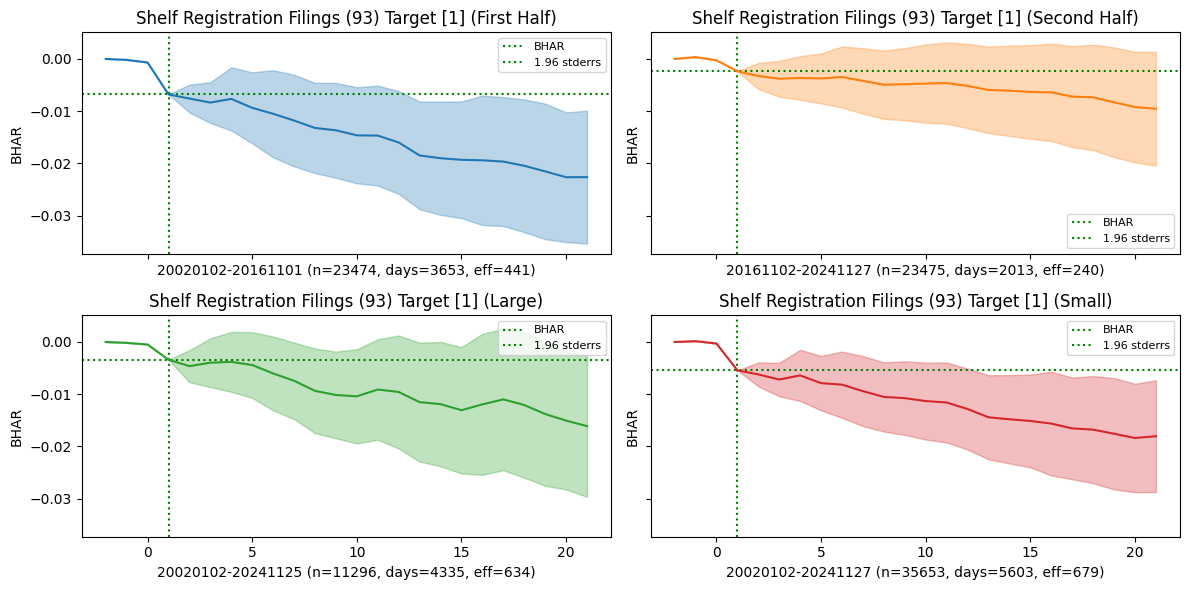

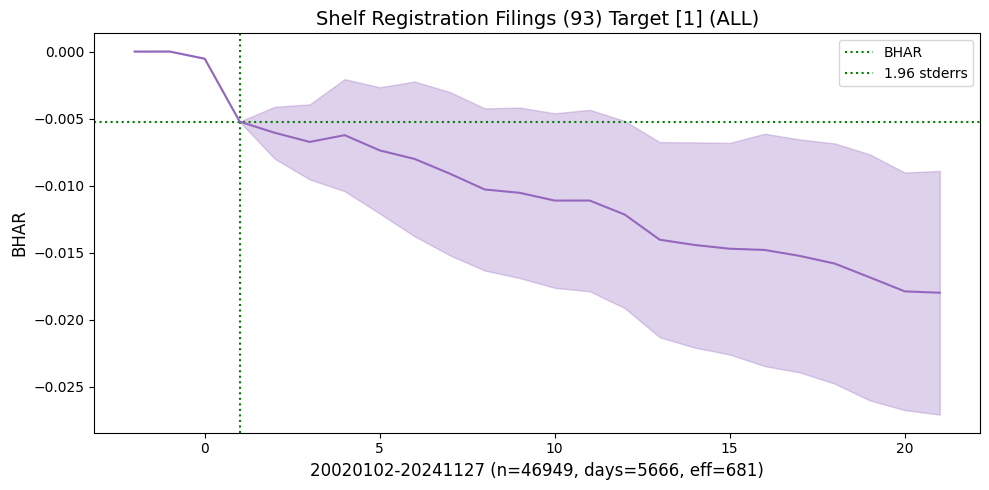

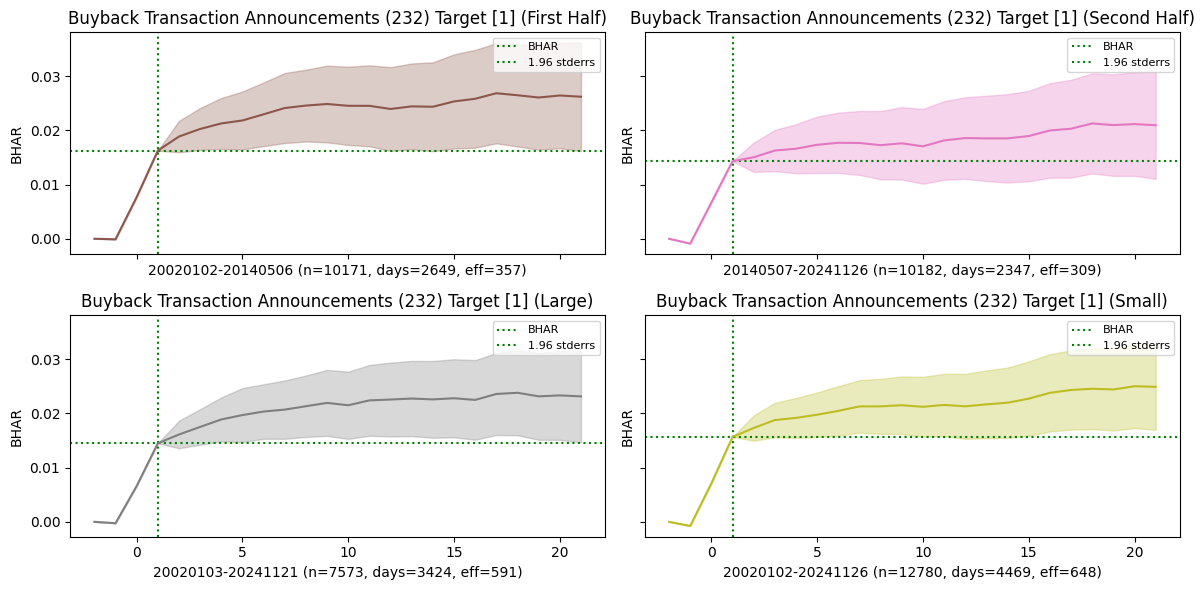

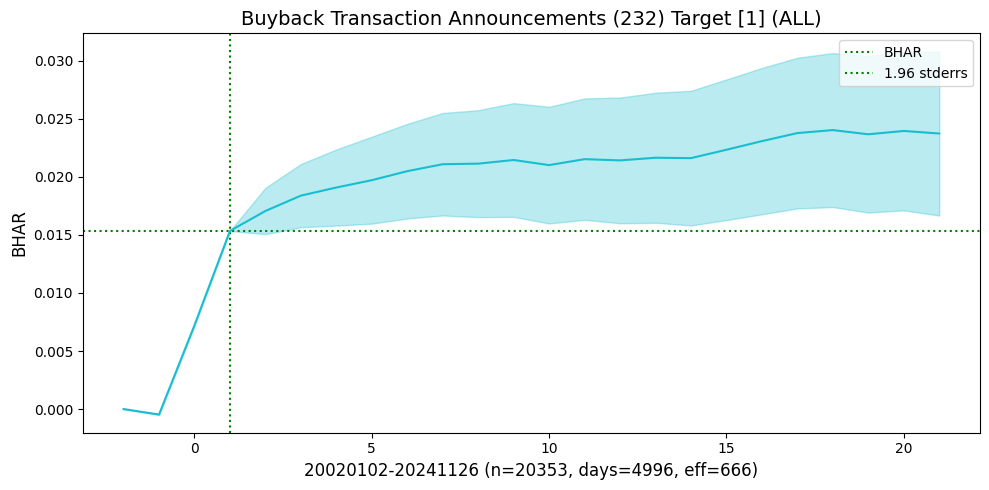

In [ ]:
events_list = [[93, 1], [232, 1]]  # largest drift returns
for i, (eventid, roleid) in enumerate(events_list):
    df = event_pipeline(eventstudy,
                        eventid=eventid,
                        roleid=roleid,
                        beg=beg,
                        end=end,
                        left=left,
                        right=right,
                        post=post)
    halfperiod = np.median(df['announcedate'])
    sample = {'First Half': df['announcedate'].lt(halfperiod).values,
              'Second Half': df['announcedate'].ge(halfperiod).values,
              'Large': df['size'].le(5).values,
              'Small': df['size'].gt(5).values,
              'ALL': [],
             }
    fig, axes = plt.subplots(nrows=2, ncols=2, clear=True, figsize=(12, 6),
                             sharex=True, sharey=True)
    axes = axes.flatten()
    for ifig, (label, rows) in enumerate(sample.items()):
        if ifig >= len(axes):
            plt.show()
            fig, ax = plt.subplots(clear = True, figsize=(10, 5))
        else:
            ax = axes[ifig]
        bhar = eventstudy.fit(model='sbhar', rows=rows)
        eventstudy.plot(model='sbhar',
                        title=eventformat(eventid, roleid) + f" ({label})",
                        drift=True,
                        ax=ax,
                        fontsize=(8 if ifig < len(axes) else 10),
                        c=f"C{i*5+ifig}")
        plt.tight_layout()
        plt.savefig(imgdir / (label + f"{eventid}_{roleid}.jpg"))
    plt.show()

Examine and show subsample plots for events that exhibited large announcement window returns

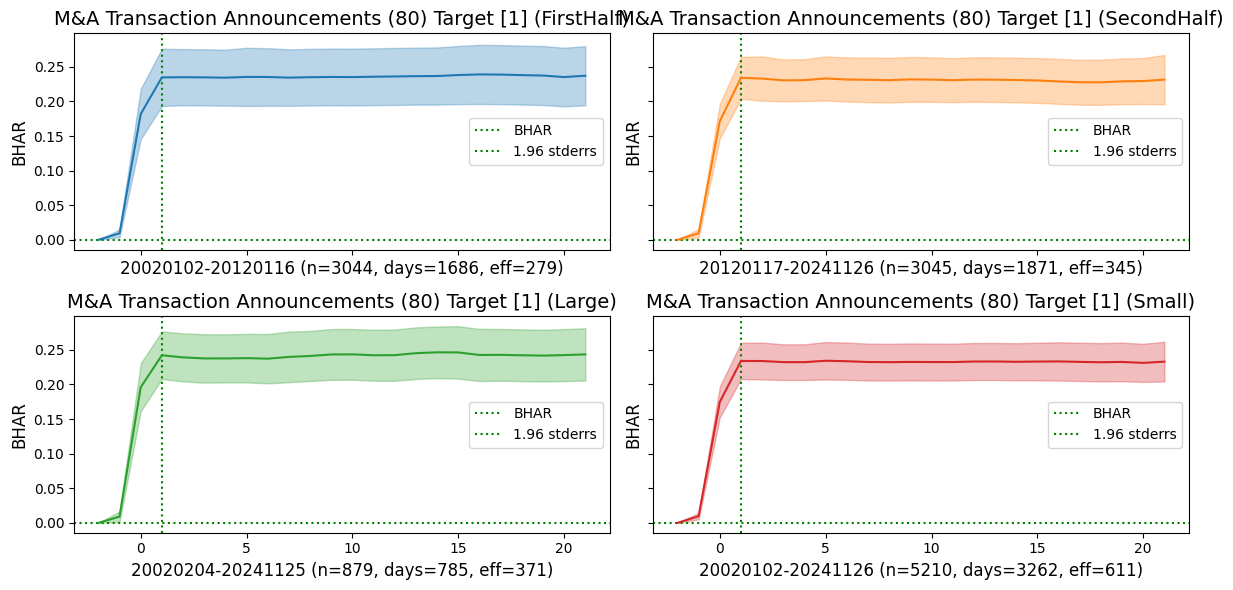

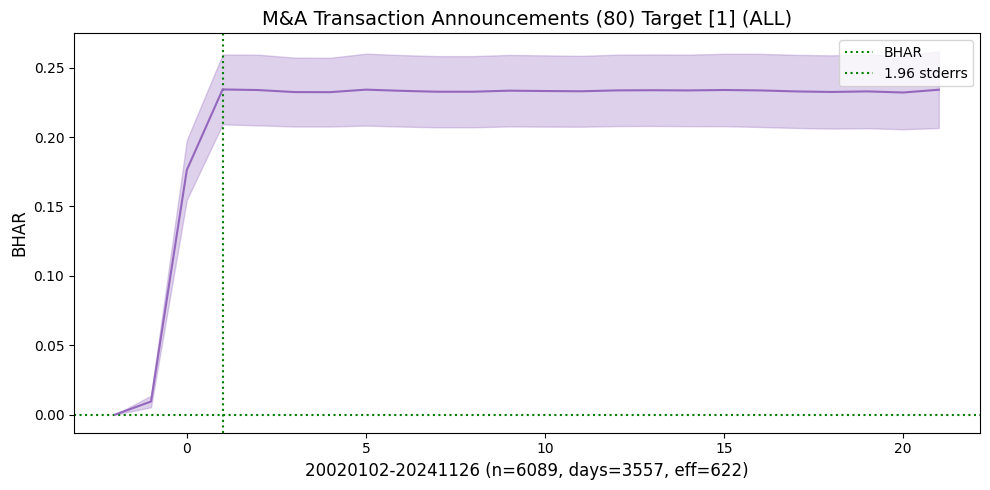

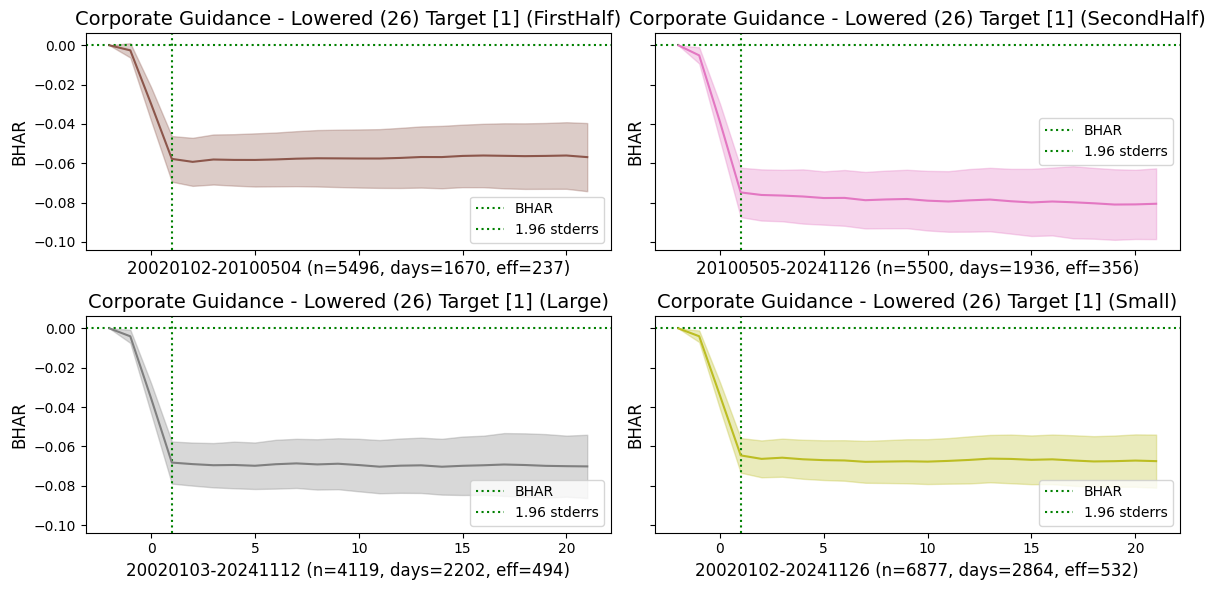

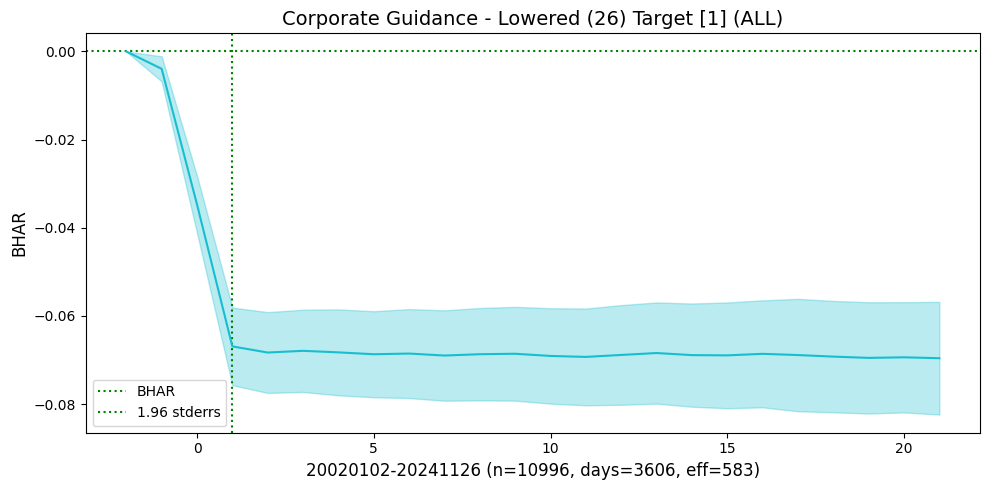

In [22]:
events_list = [[80,1], [26,1]]  # largest announcement window returns
for i, (eventid, roleid) in enumerate(events_list):
    #eventid, roleid = 50, 1
    #eventid, roleid = 83, 1
    df = event_pipeline(eventstudy,
                        eventid=eventid,
                        roleid=roleid,
                        beg=beg,
                        end=end,
                        left=left,
                        right=right,
                        post=post)
    halfperiod = np.median(df['announcedate'])
    sample = {'FirstHalf': df['announcedate'].lt(halfperiod).values,
              'SecondHalf': df['announcedate'].ge(halfperiod).values,
              'Large': df['size'].le(5).values,
              'Small': df['size'].gt(5).values,
              'ALL': []}
    fig, axes = plt.subplots(nrows=2, ncols=2, clear=True, figsize=(12, 6),
                             sharex=True, sharey=True)
    axes = axes.flatten()
    for ifig, (label, rows) in enumerate(sample.items()):
        if ifig >= len(axes):
            plt.show()
            fig, ax = plt.subplots(clear = True, figsize=(10, 5))
        else:
            ax = axes[ifig]
        bhar = eventstudy.fit(model='sbhar', rows=rows)
        eventstudy.plot(model='sbhar',
                        title=eventformat(eventid, roleid) + f" ({label})",
                        drift=False,
                        ax=ax,
                        c=f"C{i*5+ifig}")
        plt.tight_layout()
        plt.savefig(imgdir / (label + f"{eventid}_{roleid}.jpg"))
    plt.show()

## Fourier transforms

### Cross-sectional Correlations  

Kolari et al. (2018) address event windows that **partially overlap in calendar time**. To account for this overlap and cross-sectional correlation effects, they adjust the variance estimate as follows:

$$
\sigma^{2} = \dfrac{s^2}{n} m (1 + \tau (n - 1) \rho)
$$

where:
- $ m $ = length of the event window,  
- $ \tau $ = proportion of overlapping days between event windows,  
- $ \rho $ = ratio of average covariance between abnormal returns to their variance.

If all events share the same calendar date, such that all event windows fully overlap, then $ \rho $ simplifies to the average cross-sectional correlation of residuals during the estimation period.

To estimate $ \rho $, we assume cross-sectional correlations arise mainly from time misalignment. By shifting and aligning event window residuals for each stock pair to maximize their correlation, we approximate $ \rho $ as the average of these best-aligned correlations.  We leverage the methodology of Fourier transforms and convolutions to effeciently compute all pairs of correlations.


### Fast Fourier Transforms

Fourier transforms allow us to express a time series (or any function) as a sum of sinusoids. Given a function over an interval of length \( L \), we can decompose it into sinusoidal components with periods \( L, L/2, L/3, \) etc. Each component has:
- A magnitude (scale factor)
- A phase (shift)
- A frequency (inverse of the period)

This means that any function can be represented as a weighted sum of sinusoidal waves. By using complex numbers, we can efficiently store and manipulate these sinusoidal components in Fourier space rather than the original time domain. The **Fast Fourier Transform (FFT)** is an efficient algorithm for computing the **Discrete Fourier Transform (DFT)**. The DFT converts a sequence of time-domain data points into its sinusoidal coefficients, converting it from real space to frequency space. The **Inverse Fast Fourier Transform** reconstructs the original function.

### Convolution Theorem

**Convolution** is a mathematical operation that combines two functions ($ f $ and $ g $) to produce a third function ($ f * g $), expressing how one function modifies the other:

$$
(f * g)(t) = \int_{-\infty}^{\infty} f(s) g(t - s) ds
$$

In **one dimension**, convolution acts like a **moving average**, smoothing a time series by weighting neighboring values. In **two dimensions**, it applies filters (e.g., blurring, edge detection) in image processing.

In signal processing, frequency-domain techniques efficiently compute cross-correlations across various time shifts. Instead of directly computing correlations for every possible lag (which is computationally expensive), we leverage the **Convolution Theorem**. A key property of Fourier transforms is that convolution in the time domain corresponds to multiplication in the frequency domain. 

$$
\mathcal{F}\{f(t) * g(t)\} = \mathcal{F}\{f(t)\} \mathcal{F}\{g(t)\}
$$

Since direct convolution requires $O(N^2)$ operations, computing it directly is slow. However:
1. We can first apply the Fast Fourier Transform (FFT) to convert both functions into frequency space in $O(N \log N)$ time.
2. In frequency space, convolution is just element-wise multiplication of Fourier coefficients, which is very fast.
3. We then apply the Inverse FFT (IFFT) to obtain the final result in $O(N \log N)$ time.


In [11]:
# best alignment and cross-correlation using convolution theorem method
from scipy.fft import rfft, irfft
def fft_align(X):
    """Find best alignment, max cross-correlation and indices of all pairs of columns"""

    def _normalize(X: np.ndarray) -> np.ndarray:
        """Helper to demean columns and divide by norm"""
        X = X - np.mean(X, axis=0)
        X = X / np.linalg.norm(X, axis=0)
        return X

    N, M = X.shape
    X = np.pad(_normalize(X), [(0, N), (0,0)])  # normalize and zero pad
    Y = rfft(np.flipud(X), axis=0)              # FFT of all series flipped
    X = rfft(X, axis=0)                         # FFT of all original series
    corr, disp, cols = [], [], []               # to accumulate results
    for col in range(M-1):  # at each iter: compute column col * all remaining columns
        conv = irfft(X[:, [col]] * Y[:, col+1:], axis=0)  # inverse of product of FFT
        corr.extend(np.max(conv, axis=0))
        shift = (N//2) + 1           # displacement location relative to center
        disp.extend(((np.argmax(conv, axis=0) + shift) % N) - shift + 1)
        cols.extend([(col, j) for j in range(col+1, M)])
    return corr, disp, cols


In [12]:
Z = np.random.uniform(size=(10000, 1))
fft_align(np.hstack((Z[:-1], Z[1:])))


([0.9998967076018761], [1], [(0, 1)])

In [13]:
#fft_align(np.hstack(np.hstack((Z[:-5], Z[5:])))[:,2:], Z[:-2]) 
fft_align(np.hstack((np.hstack((Z[:-5], Z[5:]))[:-2], Z[7:])))

([0.9997503757740265, 0.9993943885689067, 0.9996440440611477],
 [5, 7, 2],
 [(0, 1), (0, 2), (1, 2)])

## Multiple testing

When testing a huge number of null hypotheses, we are bound to get
some very testing small p-values by chance.  __Data snooping__ occurs when the analyst fits a great number of models to a dataset. When explanatory variables are selected using the data,
t-ratios and F-ratios will be too large, thus overstating the
importance of variables in the model. **Multiple testing** adjusts the hurdle for significance because some tests will appear significant by chance. The downside of doing this is that some truly significant strategies might be overlooked because they
did not pass the more stringent hurdle. This is the classic tension between Type I errors and Type II errors. The Type I error is the false discovery (investing in an unprofitable trading strategy). The Type II error is missing a truly profitable trading strategy.

The **Family-Wise Error Rate (FWER)** controls the probability of making **at least one** false discovery. If all $ m $ null hypotheses are independent and true:

$$
\mathrm{FWER}(\alpha) = 1 - (1 - \alpha)^m
$$

To maintain a stricter significance threshold, the **Bonferroni correction** divides the confidence level by the number of tests:

$$
\alpha' = \frac{\alpha}{m}
$$

This ensures that across multiple tests, the probability of making even **one** false discovery remains below $ \alpha $. However, it can be overly conservative.

The **false discovery rate (FDR)** controls the proportion of false positives among rejected hypotheses. The **Benjamini-Hochberg (BH) procedure** is a widely used method for FDR control. Instead of adjusting individual significance thresholds like Bonferroni, BH ranks p-values and sets a significance cutoff where false discoveries remain within acceptable limits.



Compute BHAR and CAR of all events


 45%|████▍     | 52/116 [20:04:50<22:46:35, 1281.17s/it]/home/terence/Dropbox/github/data-science-notebooks/finds/recipes/filters.py:28: RuntimeWarning: invalid value encountered in divide
  X = X / np.linalg.norm(X, axis=0)
 53%|█████▎    | 62/116 [23:27:18<18:41:48, 1246.45s/it]/home/terence/Dropbox/github/data-science-notebooks/finds/recipes/filters.py:28: RuntimeWarning: invalid value encountered in divide
  X = X / np.linalg.norm(X, axis=0)
 61%|██████    | 71/116 [26:38:56<16:18:29, 1304.66s/it]/home/terence/Dropbox/github/data-science-notebooks/finds/recipes/filters.py:28: RuntimeWarning: invalid value encountered in divide
  X = X / np.linalg.norm(X, axis=0)
100%|██████████| 116/116 [42:41:25<00:00, 1324.87s/it]  


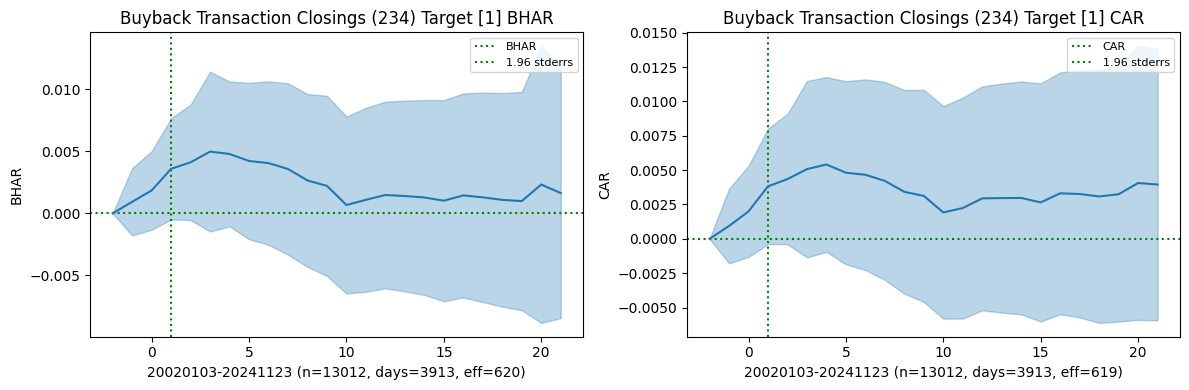

In [14]:
restart_event = 0 # 75,1
for i, eventid in tqdm(enumerate(events), total=len(events)):
    if eventid <= restart_event:  # kludge to resume loop
        continue
    for roleid in roles:
        # retrieve all returns observations of this eventid, roleid
        df = event_pipeline(eventstudy,
                            beg=beg,
                            end=end,
                            eventid=eventid,
                            roleid=roleid,
                            left=left,
                            right=right,
                            post=post)
        if df['announcedate'].nunique() < mindays:  # require min number of dates
            continue

        # compute both BHAR and CAR averages, then plot and save
        bhar = eventstudy.fit(model='sbhar')
        car = eventstudy.fit(model='scar')
        #eventstudy.write()
        eventstudy.write_summary()
        #print(eventstudy.label, eventid, roleid)

        fig, axes = plt.subplots(1, 2, clear=True, figsize=(12, 4), num=1)
        eventstudy.plot(model='sbhar', ax=axes[0],
                        title=eventformat(eventid, roleid) + ' BHAR',
                        fontsize=8, vline=[right])
        eventstudy.plot(model='scar', ax=axes[1],
                        title=eventformat(eventid, roleid) + ' CAR',
                        fontsize=8, vline=[right])
        plt.tight_layout()
        plt.savefig(imgdir / f"{eventid}_{roleid}.jpg")

Summarize BHAR's of all events


In [15]:
# Create (eventid, roleid) multiindex for table of all BHAR's
df = eventstudy.read_summary(model='sbhar')\
               .set_index('label')\
               .drop(columns=['rho', 'tau', 'created'])
df = df[df['effective'] > 400].sort_values('post_t')  # sorted by post drift t-stat
multiIndex = DataFrame(df.index.str.split('_').to_list()).astype(int)
df.index = pd.MultiIndex.from_frame(multiIndex, names=['eventid', 'roleid'])
df['event'] = keydev.event[df.index.get_level_values(0)].values
df['role'] = keydev.role[df.index.get_level_values(1)].values
print("Post-Announcement Drift")
pd.set_option('display.max_rows', None)
df.set_index(['event', 'role']).drop(columns=['model'])

Post-Announcement Drift


,,beg,end,rows,days,effective,window,window_t,post,post_t
event,role,,,,,,,,,
Shelf Registration Filings,Target,20020102,20241127,46949,5666,681.0,-0.005224,-2.542320,-0.012755,-2.753130
Special/Extraordinary Shareholders Meeting,Target,20040106,20241127,6183,3353,534.0,-0.002029,-0.537886,-0.018210,-1.970180
Name Changes,Target,20020430,20241121,1563,1329,454.0,0.012626,1.944510,-0.023076,-1.968600
Changes in Company Bylaws/Rules,Target,20020430,20241127,27834,4825,592.0,-0.000070,-0.024033,-0.010242,-1.815650
Product-Related Announcements,Target,20020102,20241127,209897,5767,686.0,0.005712,4.608120,-0.004112,-1.607030
M&A Transaction Closings,Target,20020108,20241125,1508,1234,430.0,0.010726,1.184190,-0.019140,-1.506510
Auditor Changes,Target,20020103,20241127,9563,3888,609.0,-0.003402,-1.173250,-0.009535,-1.433420
Executive/Board Changes - Other,Target,20020101,20241127,222258,5766,685.0,-0.000533,-0.537347,-0.003171,-1.410500
Executive Changes - CFO,Target,20020102,20241127,22715,5544,677.0,-0.007618,-3.312440,-0.006563,-1.390520


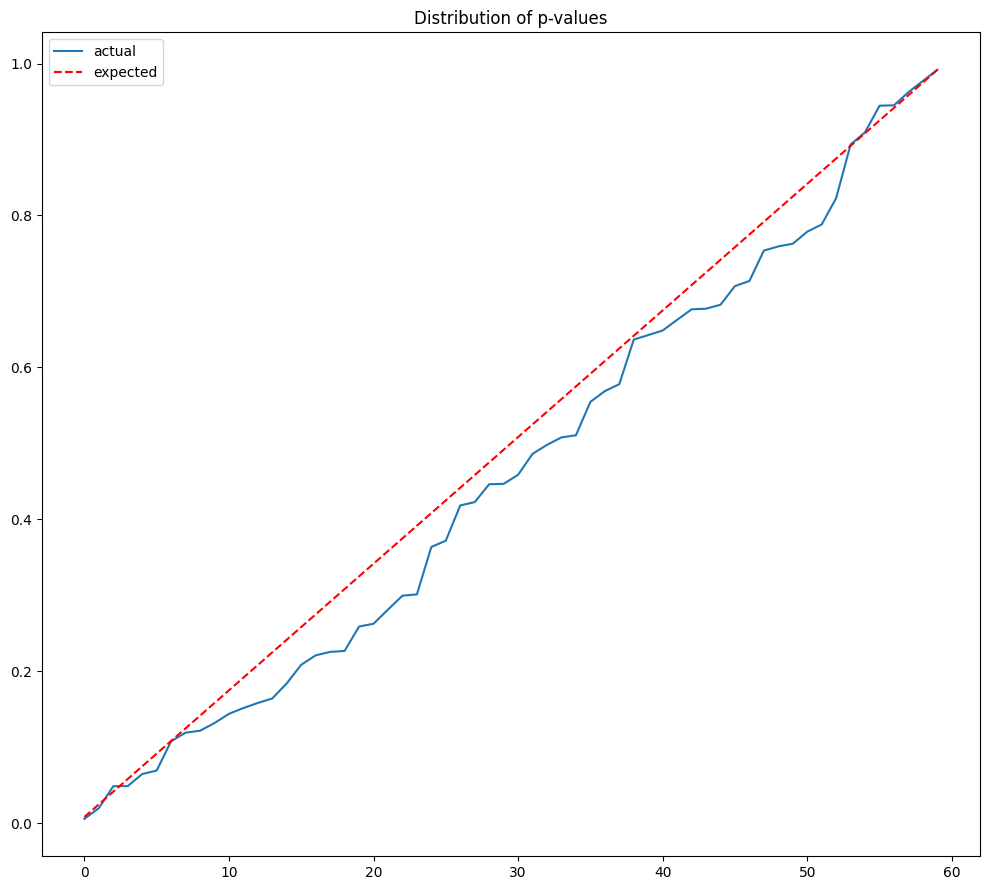

In [16]:
# Expected p-values (with continuity correction)
pvals = norm.cdf(-df['post_t'].abs()) * 2
fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 9))
ax.plot(sorted(pvals))
ax.plot([0, len(pvals)-1], [0.5/len(pvals), (len(pvals)-0.5)/len(pvals)], 'r--')
ax.set_title('Distribution of p-values')
ax.legend(['actual', 'expected'])
plt.tight_layout()

In [17]:
# Number of rejections with uncorrected pvals
#argmin = np.argmin(pvals)
#header = df.iloc[argmin][['event', 'role', 'days', 'effective', 'post_t']]
alpha = 0.05
uncorrected = DataFrame({'rejections': sum(pvals < alpha),
                         'min p-value': min(pvals)},
                        index=['uncorrected'])
uncorrected.round(4)

,rejections,min p-value
uncorrected,4,0.0059


### Bonferroni correction


The best-known FWER test is called the Bonferroni test which adjusts for the multiple tests. Given the chance that one test could randomly show up as significant, the Bonferroni requires the confidence level to increase. Instead of 5\%, you take the 5\% and divide by the number of tests, that is, 5\%/10 = 0.5\%. Again equivalently, you need to be 99.5\% confident with 10 tests that you are not making a single false discovery. In terms of the t-statistic, the Bonferroni requires a statistic of at least 2.8 for 10 tests. For 1,000 tests, the statistic must exceed 4.1.

It sets the threshold for rejecting each hypothesis to $\alpha/m$, by applying the union bound inequality:

  $$\mathrm{FWER}(\alpha) = \mathrm{Pr}(\cup_{j=1}^{m} A_j) \le                                  
  \sum_{j=1}^{m} \mathrm{Pr}(A_j) \le m \times \frac{\alpha}{m} = \alpha$$

where $A_j$ denotes the probability of rejecting the $j$-th
hypothesis. The Bonferroni correction can be quite conservative, in
the sense that the true FWER is often quite a bit lower than the
nominal (or target) FWER;




In [18]:
# The Bonferroni p-values bonf are simply the uncorrected pvalues multiplied by
# the number of samples and truncated to be less than or equal to 1.  
reject, bonf_corrected, _, _ =  multipletests(pvals, alpha=alpha, method='bonferroni')
bonf = DataFrame({'rejections': np.sum(bonf_corrected < alpha),
                  'min p-value': np.min(bonf_corrected)},
                 index=['bonferroni'])
pd.concat([uncorrected, bonf], axis=0).round(4)

,rejections,min p-value
uncorrected,4,0.0059
bonferroni,0,0.3542


### Holm's step-down procedure

Holm's method, also known as Holm's step-down procedure or the Holm-Bonferroni method, is an alternative to the Bonferroni procedure. Holm's method method controls the FWER, but it is less conservative than Bonferroni, in the sense that it will reject more null hypotheses, typically resulting in fewer Type II errors and hence greater power. Holm's method makes no independence assumptions about the hypothesis tests, and is uniformly more powerful than the Bonferroni method -- it will always reject at least as many null hypotheses as Bonferroni-- and so it should always be preferred. It is worth noting that in Holm's procedure, the threshold that we use to reject each null hypothesis actually depends on the values of all the p-values.

The Holm method begins by sorting the tests from the lowest p-value (most significant) to the highest (least significant), and comparing a threshold computed with the Holm function.  In contrast to the Bonferroni, which has a single threshold for all tests, the other tests will have a different hurdle under Holm. Starting from the first test, we sequentially compare the p-values with their hurdles. When we first come across the test such that its p-value fails to meet the hurdle, we reject this test and all others with higher p-values.



In [19]:
# Holm method
reject, holm_corrected, _, _ =  multipletests(pvals, alpha=alpha, method='holm')
holm = DataFrame({'rejections': np.sum(holm_corrected < alpha),
                  'min p-value': np.min(holm_corrected)},
                 index=['holm'])
pd.concat([uncorrected, bonf, holm], axis=0).round(4)

,rejections,min p-value
uncorrected,4,0.0059
bonferroni,0,0.3542
holm,0,0.3542


### Benjamin-Hochberg procedure

The false discovery rate approach allows an expected proportional error rate.  As such, it is less stringent than both the Bonferroni and the Holm test. FDR control is much milder -- and more powerful -- than FWER control, in the sense that it allows us to reject many more null hypotheses, with a cost of substantially more false positives.

Similar to the Holm test, Benjamin-Hochberg also relies on the distribution of test statistics. However, in contrast to the Holm test that begins with the most significant test, the Benjamin-Hochberg approach starts with the least significant.
We sort the tests from the lowest p-value (most significant) to the highest (least significant). Starting from the last test, we sequentially compare the p-values with their Benjamin-Hochberg thresholds. When we first come across the test such that its p-value falls below its threshold, we declare this test significant and all tests that have a lower p-value. 

The `multipletests` function can be used to carry out the Benjamini–Hochberg procedure.  The q-values output by the Benjamini–Hochberg procedure can be interpreted as the smallest FDR threshold at which we would reject a particular null hypothesis. For instance, a q-value of 0.1 indicates that we can reject the
corresponding null hypothesis at an FDR of 10% or greater, but that we cannot reject the null hypothesis at an FDR below 10%.

In [20]:
# Benjamini-Hochberg method
reject, fdr_bh_corrected, _, _ =  multipletests(pvals, alpha=alpha, method='fdr_bh')
fdr_bh = DataFrame({'rejections': np.sum(fdr_bh_corrected < alpha),
                    'min p-value': np.min(fdr_bh_corrected)},
                   index=['fdr_bh'])
pd.concat([uncorrected, bonf, holm, fdr_bh], axis=0).round(4)

,rejections,min p-value
uncorrected,4,0.0059
bonferroni,0,0.3542
holm,0,0.3542
fdr_bh,0,0.3542


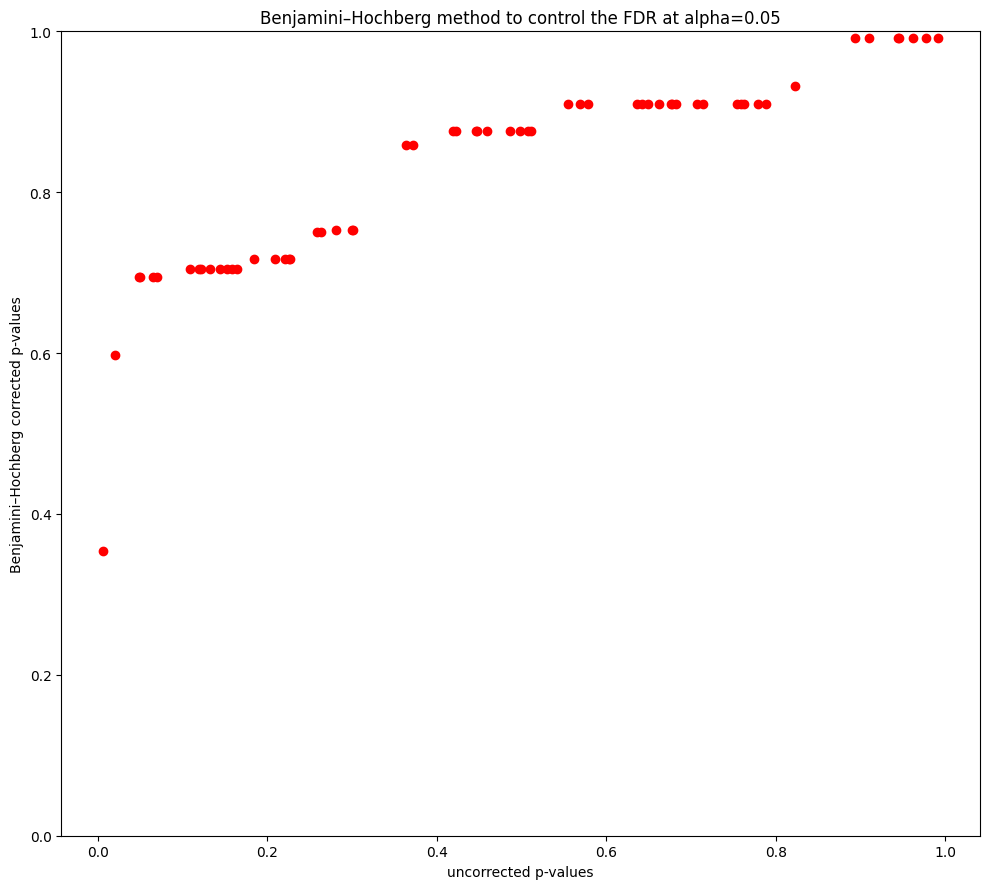

In [21]:
# Plot uncorrected and corrected p-values from Benjamini-Hochberg method
fig, ax = plt.subplots(figsize=(10, 9))
ax.scatter(pvals, fdr_bh_corrected, color='red')
ax.set_ylim(bottom=0, top=1)
ax.set_title(f"Benjamini–Hochberg method to control the FDR at alpha={alpha}")
ax.set_xlabel('uncorrected p-values')
ax.set_ylabel('Benjamini–Hochberg corrected p-values')
plt.tight_layout()


**References**

Kolari, James W. and Pynnonen, Seppo, 2010, "Event Study Testing with Cross-sectional Correlation of Abnormal Returns". The Review of Financial Studies, 23(11), 3996-4025

Kolari, James W., Paper, Bernd, and Pynnonen, Seppo, 2018, "Event Study Testing with Cross-sectional Correlation Due to Partially Overlapping Event Windows", working paper

MacKinlay, A. Craig "Event Studies in Economics and Finance", Journal of Economic Literature, March 1997.

*MIT License.  Copyright 2021-2025 Terence Lim*